# 1. Environment Setting

## (1) Import Modules

In [1]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## (2) Support Function for binalization

### 1) OtsuThreshold

In [2]:
def OtsuThreshold(img):
    maxval = np.max(img)
    vectimg = np.reshape(img,[img.shape[0]*img.shape[1],])
    histData = np.uint8(np.zeros([maxval+1,1]))
    for i in vectimg:
        histData[i]=histData[i]+1
    
    total = vectimg.shape[0]
    sum_ = 0
    for i in range(256): 
        sum_ = sum_+ i*histData[i]
        
    sumB = 0
    wB = 0
    wF = 0
    varMax = (float)(0)
    threshold = 0;
    for i in range(256):
        wB = wB + histData[i]
        if(wB==0):
            continue
        wF = total-wB;
        if(wF==0):
            break
        sumB = sumB + i*histData[i]
        mB = sumB/(float)(wB)
        mF = (sum_-sumB)/(float)(wF)
        varBetween = wB*wF*(mB-mF)*(mB-mF)
        if(varBetween>varMax):
            varMax = varBetween
            threshold = i
    binaryim = np.uint8(np.zeros(img.shape))
    binaryim[img>threshold] = 255;
    return binaryim

### 2) C-means Clustering

In [3]:
# Function based C_means Clustering
def LUT2label(im,LUT):
    Imin = np.min(im)
    Imax = np.max(im)
    I =np.array(range(Imin,Imax+1))
    I = I.reshape([I.shape[0],1])
    L = np.zeros([im.shape[0],im.shape[1]],dtype=int)
    for k in range(np.max(LUT)+1):
        i = np.where(LUT==k)[0]
        i1 = int(i[0])
        
        if(i.size>1):
            i2=int(i[-1])
        else:
            i2=i1
        
        bw = np.where((im>I[i1]) & (im<I[i2]))
        for j in range(bw[0].size):
            L[bw[0][j],bw[1][j]] = k

    return L
 
# C_means Clustering    
def FastCmeans(im,c=2):
    Imin = np.min(im)
    Imax = np.max(im)
    I =np.array(range(Imin,Imax+1))
    I = I.reshape([I.shape[0],1])
    H = np.zeros([I.shape[0],1],dtype=int)
    k = im.shape[0]*im.shape[1]
    imshap =im.shape
    im = im.reshape([im.shape[0]*im.shape[1],1])
    for i in range(k):
        H[im[i]-Imin]=H[im[i]-Imin]+1 
        
    dl=(Imax-Imin)/c
    C=np.arange(Imin+dl/2,Imax,dl)
    IH = np.multiply(H,I)
    dC = float("inf")
    
    while(dC>1e-6):
        C0 =C
        D = np.ndarray([I.shape[0],0])
        for i in range(C.shape[0]):
            D = np.concatenate((D,np.subtract(I,C[i])),axis=1)
        
        D = np.abs(D)
        LUT = np.argmin(D,axis=1)
        C = np.double(C)
        for i in(range(c)):
            C[i]=np.sum(np.uint(IH[LUT==i]))/np.sum(np.uint(H[LUT==i]))
            
        dC = np.max(np.abs(np.subtract(C,C0))) 

    L =LUT2label(im,LUT)
    L = L.reshape(imshap)
    return L

## (2) Read Test Image

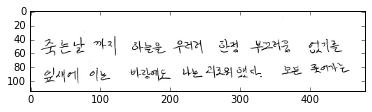

In [4]:
imag = cv2.imread("Prec.jpg",0)
imag = cv2.resize(imag,(imag.shape[1]/2,imag.shape[0]/2),interpolation=cv2.INTER_CUBIC)
plt.imshow(imag,'gray')
plt.show()

# 2. Preprocessing

## (1) Reverse Image for Morphism

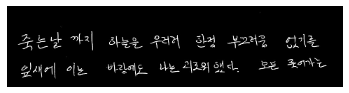

In [4]:
imag = np.uint8(np.ones(imag.shape)*255-imag)
rows,cols= imag.shape
plt.imshow(imag,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

## (2) Binalization

### 1) Fast-Cmeans clustering

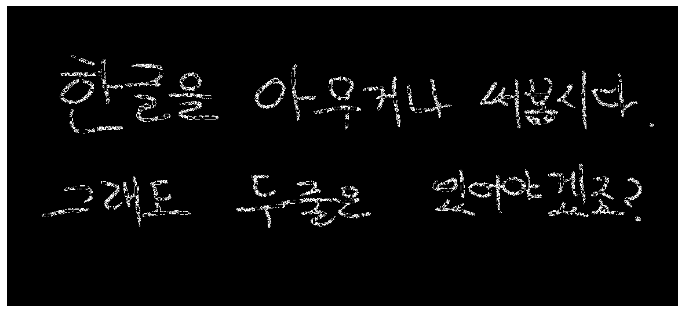

In [1150]:
L = FastCmeans(imag)
onenum = np.where(L==1)[0].size
zeronum = np.where(L==0)[0].size
if(onenum>zeronum):
    L=np.ones(L.shape)- L
Cmeans = np.float32(np.multiply(L,255))
plt.figure(figsize=(12,20))
plt.imshow(Cmeans,'gray')
#plt.title('Fast-Cmeans Clustering')
plt.xticks([])
plt.yticks([])
plt.show()

### 2) Otsu-Threshold

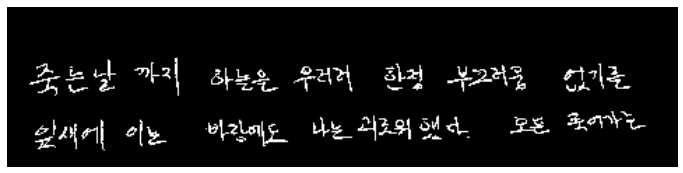

In [5]:
Otsuimag = OtsuThreshold(imag)
plt.figure(figsize=(12,20))
plt.imshow(Otsuimag,'gray')
#plt.title('OtsuThreshold')
plt.xticks([])
plt.yticks([])    
plt.show()

### 3) Adaptive Gaussian Threshold

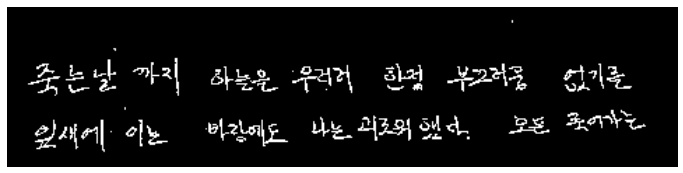

In [6]:
gaussian = cv2.adaptiveThreshold(np.uint8(np.ones(imag.shape)*255-imag),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
gaussian = np.ones(gaussian.shape)*255-gaussian
plt.figure(figsize=(12,20))
plt.imshow(gaussian,'gray')
#plt.title('Adaptive Gaussain Threshold')
plt.xticks([])
plt.yticks([])
plt.show()

## (3) Closing For Binary Image

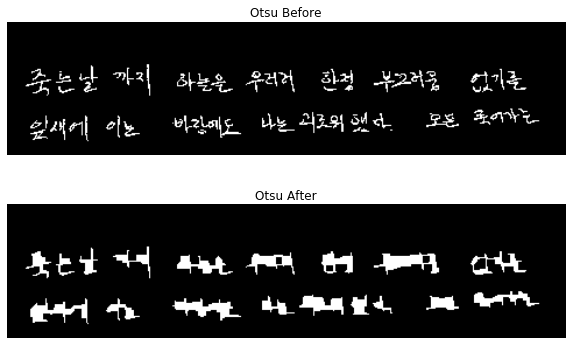

In [7]:
kernel = np.ones((5,5),np.uint8)

Otsu_closing = cv2.morphologyEx(Otsuimag,cv2.MORPH_CLOSE,kernel)


images = [Otsuimag,Otsu_closing]
titles = ['Otsu Before','Otsu After']
plt.figure(figsize=(10,6))
for i in range(2):
    plt.subplot(2,1,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    
plt.show()

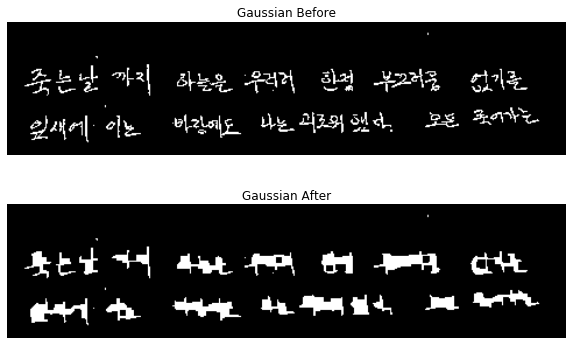

In [8]:
kernel = np.ones((5,5),np.uint8)
Gaussian_closing = cv2.morphologyEx(gaussian,cv2.MORPH_CLOSE,kernel)
images = [gaussian,Gaussian_closing]
titles = ['Gaussian Before','Gaussian After']
plt.figure(figsize=(10,6))
for i in range(2):
    plt.subplot(2,1,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    
plt.show()

# 3. Text-line Segmentation

## Find strip-width

In [9]:
binaryimg = np.uint8(Gaussian_closing/255)
imagesum = np.sum(binaryimg)/(float)(rows*cols)
stripwidth = 0
if(imagesum>=0.2):
    stripwidth = 0.05*cols
elif(imagesum>0.1):
    stripwidth = 0.1*cols
else:
    stripwidth = 0.25*cols

stripwidth = int(math.ceil(stripwidth))

In [10]:
cols/(float)(stripwidth)

4.0

In [11]:
rangemat= range(0,cols,stripwidth)

## Projection to y axis

In [12]:
proj = np.zeros([rows,(int)(math.ceil(cols/(float)(stripwidth)))])
rangemat = range(0,cols,stripwidth)
for i in xrange(0,cols/stripwidth):
    proj[:,i]=np.sum(Gaussian_closing[:,rangemat[i]:rangemat[i]+stripwidth-1],axis=1)    

if(cols%stripwidth!=0):    
    proj[:,-1] = np.uint(np.sum(Gaussian_closing[:,rangemat[i+1]:],axis=1))

proj2 = np.zeros([proj.shape[0]+9,proj.shape[1]])
proj2[4:-5,:]= proj
for i in range(rows):
    proj[i,:] = np.sum(proj2[i-4:i+5,:],axis=0)
    
proj = proj/9
x = range(proj.shape[0])
alpha = 5;

threshold = np.sum(proj,axis = 0)/(alpha*rows)



In [13]:
proj2[i-4:i+5,:]

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [14]:
range(0,cols/stripwidth)

[0, 1, 2, 3]

In [15]:
stripwidth

120

In [16]:
rangemat

[0, 120, 240, 360]

In [17]:
proj

array([[     0.        ,      0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ,     28.33333333],
       [     0.        ,      0.        ,      0.        ,     56.66666667],
       [     0.        ,      0.        ,      0.        ,     56.66666667],

## result of Adjust Threshold

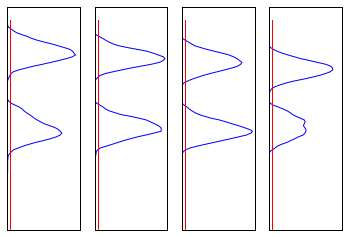

In [18]:
for i in xrange(len(rangemat)):
    plt.subplot(1,len(rangemat),i+1)
    plt.plot(proj[:,i],x)
    plt.plot(np.ones(proj[:,i].shape)*threshold[i],x,'r-')
    plt.xticks([])
    plt.yticks([])
plt.show()

## Calculate Above Boundary and Below Boundary

In [20]:
AB = np.array([])
BB = np.array([])
ABConf = False
for j in range(rows):
    if(proj[j,0]>threshold[0] and proj[j-1,0]<=threshold[0]):
        AB = np.concatenate((AB,[j-2]))
        ABConf=True
    if((proj[j,0]>threshold[0] and proj[j+1,0]<=threshold[0])and(ABConf)):
        BB = np.concatenate((BB,[j+2]))
        ABConf = False

BBi = np.uint8(np.zeros(BB.shape))
ABi = np.uint8(np.ones(AB.shape)*rows)
        
for i in range(1,len(rangemat)):
    BBi = np.zeros(BBi.shape)
    ABi = np.ones(ABi.shape)*rows
    A_i = 0
    B_i = 0
    for j in range(rows):
        if(proj[j,i]>threshold[i] and proj[j-1,i]<=threshold[i]):
            ABi[A_i] = j-2
            A_i += 1
            ABConf=True
        if((proj[j,i]>threshold[i] and proj[j+1,i]<=threshold[i])and(ABConf)):
            BBi[B_i] = j+2
            B_i += 1
            ABConf = False
            
    AB = np.vstack((AB,ABi))
    BB = np.vstack((BB,BBi))


In [21]:
i

3

In [22]:
ABi

array([ 41.,  74.])

In [23]:
BB

array([[  70.,  110.],
       [  69.,  106.],
       [  68.,  104.],
       [  69.,   99.]])

## Seperate TextLine

In [24]:
D = np.sum((np.abs(np.subtract(AB,BB))))/AB.nonzero()[0].shape[0]
#
#AB = AB.reshape([len(rangemat),AB.shape[0]/len(rangemat)])
#BB = BB.reshape([len(rangemat),BB.shape[0]/len(rangemat)])

minAB = np.uint(np.min(AB,axis=0))
maxBB = np.uint(np.max(BB,axis=0))
linenum = maxBB.shape[0]
rowmax = np.max(maxBB-minAB)

image_sep = np.uint8(np.zeros([linenum,rowmax,cols]))
image_sepb = np.uint8(np.zeros([linenum,rowmax,cols]))

AB = np.uint(AB)
BB = np.uint(BB)
for i in range(linenum):
    for j in range(len(rangemat)):
        image_sep[i,AB[j,i]-minAB[i]:BB[j,i]-minAB[i],rangemat[j]:rangemat[j]+stripwidth-1] = imag[AB[j,i]:BB[j,i],rangemat[j]:rangemat[j]+stripwidth-1]
        image_sepb[i,AB[j,i]-minAB[i]:BB[j,i]-minAB[i],rangemat[j]:rangemat[j]+stripwidth-1] = gaussian[AB[j,i]:BB[j,i],rangemat[j]:rangemat[j]+stripwidth-1]


In [25]:
minAB

array([40, 74], dtype=uint32)

### Result

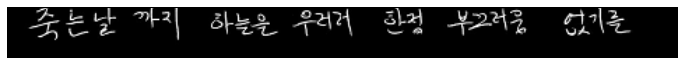

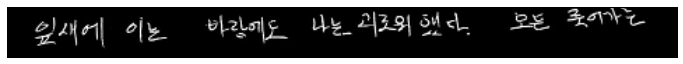

In [26]:
for i in range(image_sep.shape[0]):
        plt.figure(figsize=(12,20))
        plt.subplot(image_sep.shape[0],1,i+1)
        plt.imshow(image_sep[i,:,:],'gray')
        plt.xticks([])
        plt.yticks([])

plt.show()

# Coarse Segmentation with SWT

## Stroke Width Transform

In [1173]:
def swt(source):
    result = cv2.distanceTransform(source,cv2.cv.CV_DIST_L2,5)
    minVal,maxVal,minLoc,maxLoc=cv2.minMaxLoc(result)
    strokeradius = np.uint8(np.ceil(maxVal))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    for i in xrange(strokeradius):
        result=cv2.dilate(result,kernel)
        result = np.multiply(result,source)
    
    return result

Ge Target and AW

In [30]:
pagenum =0

In [31]:
target = image_sepb[pagenum,:,:]
target[target!=0] = 1

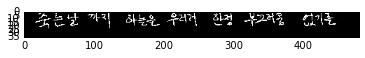

In [32]:
plt.imshow(target,'gray')
plt.show()

In [1219]:
swt_image = swt(np.uint8(target))

In [1220]:
AW = np.sum(swt_image)/np.sum(target)

y projection with target_closing image and divide it  by AW

In [1221]:
target_c =  cv2.morphologyEx(target,cv2.MORPH_CLOSE,kernel)
y_proj = np.sum(target_c,axis=0)

y_proj2 = np.zeros([y_proj.shape[0]+5,])

In [1222]:
cols = target.shape[0]
rows = target.shape[1]
y_proj2[2:-3] = y_proj
for i in range(rows):
    y_proj[i] = np.max(y_proj2[i:i+5]) # smoothing projection

Result for Coarse Segmentation using AW

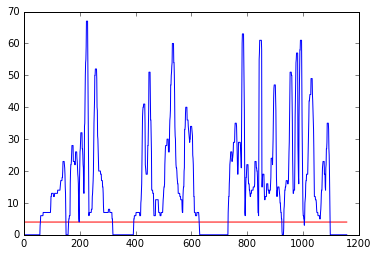

In [1223]:
plt.plot(xrange(y_proj.shape[0]),np.ones(y_proj.shape)*round(AW),'r-')
plt.plot(xrange(y_proj.shape[0]),y_proj,'b')
plt.show()


Fine Segmentation process with Labeling

In [1224]:
RB = 0
LB = 0
target[:,np.where(y_proj<round(AW))[0]] = 0
RowBoundary = np.where(y_proj<round(AW))[0]


In [1225]:
RowBoundary

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,  151,  152,  153,  154,  155,  156,  157,
        158,  159,  318,  319,  320,  321,  322,  323,  324,  325,  326,
        327,  328,  329,  330,  331,  332,  333,  334,  335,  336,  337,
        338,  339,  340,  341,  342,  343,  344,  345,  346,  347,  348,
        349,  350,  351,  352,  353,  354,  355,  356,  357,  358,  359,
        360,  361,  362,  363,  364,  365,  366,  367,  368,  369,  370,
        371,  372,  373,  374,  375,  376,  377,  378,  379,  380,  381,
        382,  383,  384,  385,  386,  387,  388,  389,  390,  391,  392,
        393,  629,  630,  631,  632,  633,  634,  6

In [1226]:
from skimage import measure

In [1227]:
target_b = target

In [1228]:
target = target_b

In [1229]:
componentlabel = 0
for i in xrange(1,len(RowBoundary)-1):
    if(RowBoundary[i]+1 != RowBoundary[i+1]):
        for j in xrange(i+1,len(RowBoundary)-1):
            if(RowBoundary[j]-1 != RowBoundary[j-1]):
                L = measure.label(target[:,RowBoundary[i]:RowBoundary[j]])
                L[L!=0] +=componentlabel
                curComMin = componentlabel
                curComMax = L.max()
                print("이건되냐 %d %d" %( RowBoundary[i] ,RowBoundary[j]))
                for i2 in xrange(curComMin+1,curComMax+1):
                    if(np.where(L==i2)[0].shape[0]<=10):
                        L[L==i2]=0
                    else:
                        componentlabel +=1
                        L[L==i2] = componentlabel
                    for k in xrange(i2+1, curComMax+1):
                        tempcomp2 = set(np.where(L==k)[1])
                        tempcomp =set(np.where(L==i2)[1])
                        if(len(tempcomp)*2./3 < len((tempcomp&tempcomp2))):  ## if projection area is overlapped more than 2/3, merege component
                            L[L==k]=componentlabel
                        elif(len(tempcomp2)*2./3 < len((tempcomp&tempcomp2))):
                            L[L==k]=componentlabel
                target[:,RowBoundary[i]:RowBoundary[j]]=L
                break

이건되냐 58 151
이건되냐 159 318
이건되냐 393 629
이건되냐 731 925
이건되냐 931 1005
이건되냐 1005 1098


In [1230]:
componentlabel

17

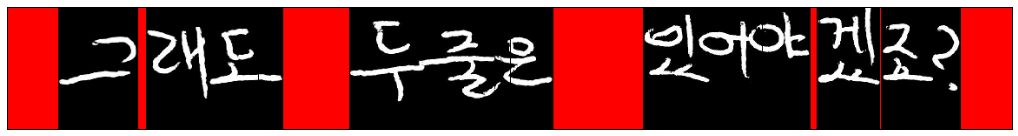

In [1231]:

imageshow = np.zeros([target.shape[0],target.shape[1],3],np.uint8)
imageshow[:,:,0] = image_sep[pagenum,:,:]
imageshow[:,:,1] = image_sep[pagenum,:,:]
imageshow[:,:,2] = image_sep[pagenum,:,:]
imageshow[:,np.where(y_proj<round(AW))[0],0]=255
plt.figure(figsize=(18,6))
plt.imshow(imageshow)
plt.xticks([])
plt.yticks([])
plt.show()

help funcion to show fine segmentation

In [1232]:
def textshow(i,target):
    
    tempimg = np.zeros(target.shape)
    tempimg[target==i]=255
    plt.figure(figsize=(18,6)) 
    plt.imshow(tempimg,'gray')
    plt.show()

In [1233]:
target.max()

17

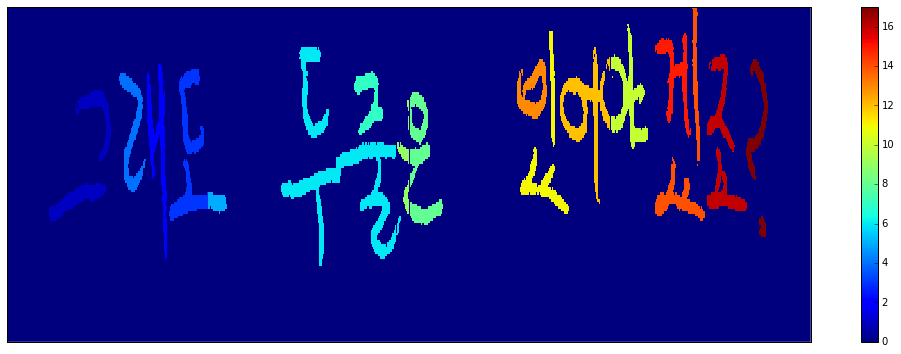

In [1234]:
plt.figure(figsize=(18,6))
plt.imshow(target, aspect='auto', interpolation='none') ## result of fine segmentation
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

# Merge  component with Wierd Clustering

In [1235]:
from sklearn import metrics

classnum = target.max()
gapdist= np.ones([classnum,3])*1000


for i in xrange(1,classnum+1):
    for j in xrange(1,classnum+1):
        if(j!=i):
            Xcenter = [[np.sum(np.where(target==i)[0])/np.where(target==i)[0].shape[0],np.sum(np.where(target==i)[1])/np.where(target==i)[0].shape[0]]]
            Ycenter = [[np.sum(np.where(target==j)[0])/np.where(target==j)[0].shape[0],np.sum(np.where(target==j)[1])/np.where(target==j)[0].shape[0]]]
            eucmetmin = metrics.pairwise.euclidean_distances(Xcenter,Ycenter).min()
            if(eucmetmin<gapdist[i-1,1]):
                gapdist[i-1,0] = j
                gapdist[i-1,1] = eucmetmin
                gapdist[i-1,2] = np.where(target==i)[0].shape[0] + np.where(target==j)[0].shape[0]

from sklearn import cluster                
model = cluster.AgglomerativeClustering()
pred=model.fit_predict(gapdist[:,1:])
componentlabel =0

for i in xrange(pred.shape[0]):
    if((pred[i]==0)&(gapdist[(int)(gapdist[i,0]-1),0] == i+1)):
        if(i+1>gapdist[i,0]):
            componentlabel+=1
            target[target == i+1] = componentlabel
            target[target == gapdist[i,0]] = componentlabel 
    else:
        componentlabel+=1
        target[target==i+1] = componentlabel
        

In [1236]:
classnum=target.max()

In [1237]:
def showbbox(classnum,target):
    imagergb = np.zeros([target.shape[0],target.shape[1],3],np.uint8)
    for i in xrange(3):
        imagergb[np.where(target!=0)[0],np.where(target!=0)[1],i]=255
        
    for i in xrange(1,classnum+1):
        if(np.where(target==i)[0].shape[0]==0):
            continue
        min0 = np.where(target==i)[0].min()
        max0 = np.where(target==i)[0].max()
        min1 = np.where(target==i)[1].min()
        max1 = np.where(target==i)[1].max()
        imagergb[min0:max0,min1,0]=255
        imagergb[min0:max0,max1,0]=255
        imagergb[min0,min1:max1,0]=255
        imagergb[max0,min1:max1,0]=255      
    
    plt.figure(figsize=(20,10))
    plt.imshow(imagergb)
    plt.xticks([])
    plt.yticks([])
    plt.show()

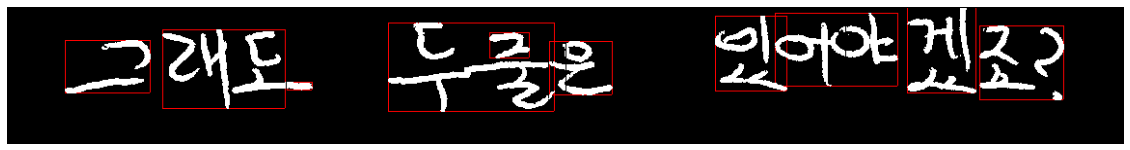

In [1238]:
showbbox(classnum,target)

In [1199]:
pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int64)

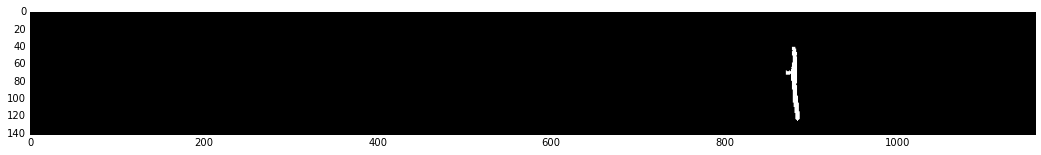

In [1200]:
textshow(9,target)

In [1201]:
classwant = 0

In [839]:

componentlabel =0

for i in xrange(pred.shape[0]):
    if((pred[i]==classwant)&(gapdist[(int)(gapdist[i,0]-1),0] == i+1)):
        if(i+1>gapdist[i,0]):
            componentlabel+=1
            target[target == i+1] = componentlabel
            target[target == gapdist[i,0]] = componentlabel 
    else:
        componentlabel+=1
        target[target==i+1] = componentlabel

classnum = target.max()
gapdist= np.ones([classnum,3])*1000

for i in xrange(1,classnum+1):
    for j in xrange(1,classnum+1):
        if(j!=i):
            Xcenter = [[np.sum(np.where(target==i)[0])/np.where(target==i)[0].shape[0],np.sum(np.where(target==i)[1])/np.where(target==i)[0].shape[0]]]
            Ycenter = [[np.sum(np.where(target==j)[0])/np.where(target==j)[0].shape[0],np.sum(np.where(target==j)[1])/np.where(target==j)[0].shape[0]]]
            eucmetmin = metrics.pairwise.euclidean_distances(Xcenter,Ycenter).min()
            if(eucmetmin<gapdist[i-1,1]):
                gapdist[i-1,0] = j
                gapdist[i-1,1] = eucmetmin
                gapdist[i-1,2] = np.where(target==i)[0].shape[0] + np.where(target==j)[0].shape[0]
pred=model.fit_predict(gapdist[:,1:])


C:\Users\kiwoong\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: RuntimeWarning: divide by zero encountered in longlong_scalars
C:\Users\kiwoong\Anaconda2\lib\site-packages\ipykernel\__main__.py:20: RuntimeWarning: divide by zero encountered in longlong_scalars


In [840]:
classnum

25

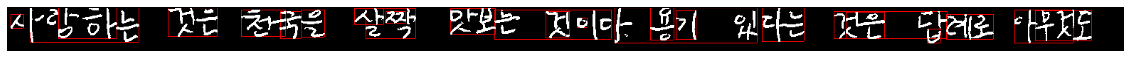

In [841]:
showbbox(classnum,target)

In [83]:
componentlabel=0
for i in xrange(1,len(RowBoundary)-1):
    if(RowBoundary[i]+1 != RowBoundary[i+1]):
        if(RB != RowBoundary[i]):
            changeflag[0] = 1
            RB = RowBoundary[i]
    if(RowBoundary[i]-1 != RowBoundary[i-1]):
        if(LB != RowBoundary[i]):
            changeflag[1] = 1
            LB = RowBoundary[i]
    if((RB<LB)&(np.sum(changeflag)==2)):
        print("Lmin is %d " %i)
        changeflag= changeflag*0
        L = target[:,RB:LB]
        L[L!=0] +=componentlabel
        for j in xrange(L.min()+1,L.max()+1):
            tempcomp =set(np.where(L==j)[1])
            if(np.where(L==j)[1].shape[0]<=7):  ## denoise small component
                L[L==j] = 0
            else:
                componentlabel +=1
                L[L==j] = componentlabel
                for k in xrange(j+1,L.max()+1):
                    tempcomp2 = set(np.where(L==k)[1])
                    if(len(tempcomp)*2./3 < len((tempcomp&tempcomp2))):  ## if projection area is overlapped more than 2/3, merege component
                        L[L==k]=componentlabel        
        target[:,RB:LB]=L

Lmin is 20 
Lmin is 33 
Lmin is 63 
Lmin is 80 
Lmin is 86 
Lmin is 89 
Lmin is 92 
Lmin is 120 
Lmin is 131 


In [314]:
from sklearn import metrics

classnum = target.max()
gapdist= np.ones([classnum,3])*1000

for i in xrange(1,classnum+1):
    for j in xrange(1,classnum+1):
        if(j!=i):
            Xcenter = [[np.sum(np.where(target==i)[0])/np.where(target==i)[0].shape[0],np.sum(np.where(target==i)[1])/np.where(target==i)[0].shape[0]]]
            Ycenter = [[np.sum(np.where(target==j)[0])/np.where(target==j)[0].shape[0],np.sum(np.where(target==j)[1])/np.where(target==j)[0].shape[0]]]
            eucmetmin = metrics.pairwise.euclidean_distances(Xcenter,Ycenter).min()
            if(eucmetmin<gapdist[i-1,1]):
                gapdist[i-1,0] = j
                gapdist[i-1,1] = eucmetmin
                gapdist[i-1,2] = np.where(target==i)[0].shape[0] + np.where(target==j)[0].shape[0]

from sklearn import cluster                
model = cluster.AgglomerativeClustering()
pred=model.fit_predict(gapdist[:,1:])

In [ ]:
classwant = 1

In [85]:
from sklearn import metrics

classnum = target.max()
gapdist= np.ones([classnum,3])*1000

for i in xrange(1,classnum+1):
    for j in xrange(1,classnum+1):
        if(j!=i):
            Xcenter = [[np.sum(np.where(target==i)[0])/np.where(target==i)[0].shape[0],np.sum(np.where(target==i)[1])/np.where(target==i)[0].shape[0]]]
            Ycenter = [[np.sum(np.where(target==j)[0])/np.where(target==j)[0].shape[0],np.sum(np.where(target==j)[1])/np.where(target==j)[0].shape[0]]]
            eucmetmin = metrics.pairwise.euclidean_distances(Xcenter,Ycenter).min()
            if(eucmetmin<gapdist[i-1,1]):
                gapdist[i-1,0] = j
                gapdist[i-1,1] = eucmetmin
                gapdist[i-1,2] = np.where(target==i)[0].shape[0] + np.where(target==j)[0].shape[0]

from sklearn import cluster                
model = cluster.AgglomerativeClustering()
pred=model.fit_predict(gapdist[:,1:])

while(pred.sum()!=0):
    

    componentlabel =0

    for i in xrange(pred.shape[0]):
        if((pred[i]==1)&(gapdist[(int)(gapdist[i,0]-1),0] == i+1)):
            if(i+1>gapdist[i,0]):
                componentlabel+=1
                target[target == i+1] = componentlabel
                target[target == gapdist[i,0]] = componentlabel 
        else:
            componentlabel+=1
            target[target==i+1] = componentlabel

    classnum = target.max()
    gapdist= np.ones([classnum,3])*1000

    for i in xrange(1,classnum+1):
        for j in xrange(1,classnum+1):
            if(j!=i):
                Xcenter = [[np.sum(np.where(target==i)[0])/np.where(target==i)[0].shape[0],np.sum(np.where(target==i)[1])/np.where(target==i)[0].shape[0]]]
                Ycenter = [[np.sum(np.where(target==j)[0])/np.where(target==j)[0].shape[0],np.sum(np.where(target==j)[1])/np.where(target==j)[0].shape[0]]]
                eucmetmin = metrics.pairwise.euclidean_distances(Xcenter,Ycenter).min()
                if(eucmetmin<gapdist[i-1,1]):
                    gapdist[i-1,0] = j
                    gapdist[i-1,1] = eucmetmin
                    gapdist[i-1,2] = np.where(target==i)[0].shape[0] + np.where(target==j)[0].shape[0]
    pred=model.fit_predict(gapdist[:,1:])


KeyboardInterrupt: 

In [177]:
target.max()

17

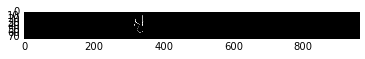

In [46]:
textshow(6,target)